In [1]:
import sys
import json
sys.path.append('..')
import tagnews
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
pd.set_option('display.width', 150)
pd.set_option('max.columns', 15)

# Determine the costs of processing existing articles

Based on complete data files from through 2019-09-07.

Each 1000 words of an article submitted is one "unit", rounded up.

1,496,665 units total = $2487 to process at once, or 300 months in free batches of 5k...

In [2]:
crimetags = tagnews.CrimeTags()

df_all = tagnews.load_data()
df_all['read_date'] = df_all['created'].str.slice(0, 10)
### Limiting it to last two years because the data volume is unstable before that
df = df_all.loc[df_all['read_date'] >= '2017-01-01']
del df_all
### Number of units to process title and article through Google Cloud API
df['n_chars'] = df['title'].str.len() + df['bodytext'].str.len()
df['n_units'] = np.ceil(df['n_chars']/1000.)

/home/rachel/Code/civic_data/article-tagging/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
../tagnews/utils/load_data.py:236: RuntimeWarning: 5 location strings were not found in the bodytext.
  RuntimeWarning)


In [3]:
def calculate_google_nlp_price(total_units, verbose=True):
    '''Cost to run entity sentiment analysis on a given number of 
    units in a single month through in Google Cloud API.
    https://cloud.google.com/natural-language/#natural-language-api-pricing
    
    First 5000 = free
    5k-1M  = $2 per 1000 units
    1M-5M  = $1 per 1000 units
    5M-20M = $0.5 per 1000 units
    '''
    free_units        = min(5e3, total_units)
    first_tier_units  = min(1e6-5e3, total_units-free_units)
    second_tier_units = min(5e6-1e6, total_units-free_units-first_tier_units)
    third_tier_units  = max(0, total_units-free_units-first_tier_units-second_tier_units)
    units = [free_units, first_tier_units, second_tier_units, third_tier_units]
    costs = [0, 2., 1., 0.5]
    total_cost = sum([c*np.ceil(u/1e3) for (c, u) in zip(costs, units)])
    if verbose:
        print('{:.0f} units: {:.0f}*0 + {:.0f}*$2 + {:.0f}*$1 + {:.0f}*$0.50 = ${:.2f}'
              .format(total_units,
                      np.ceil(free_units/1e3),
                      np.ceil(first_tier_units/1e3),
                      np.ceil(second_tier_units/1e3),
                      np.ceil(third_tier_units/1e3),
                      total_cost))
    return total_cost

In [4]:
units = df['n_units'].sum()
cost = calculate_google_nlp_price(units)

1496665 units: 5*0 + 995*$2 + 497*$1 + 0*$0.50 = $2487.00


In [5]:
units_per_day = (df
                 .groupby('read_date')
                 .agg({'url': 'count',
                       'n_units': 'sum'})
                )
print(units_per_day.index.min(), units_per_day.index.max())

2017-01-01 2019-09-07


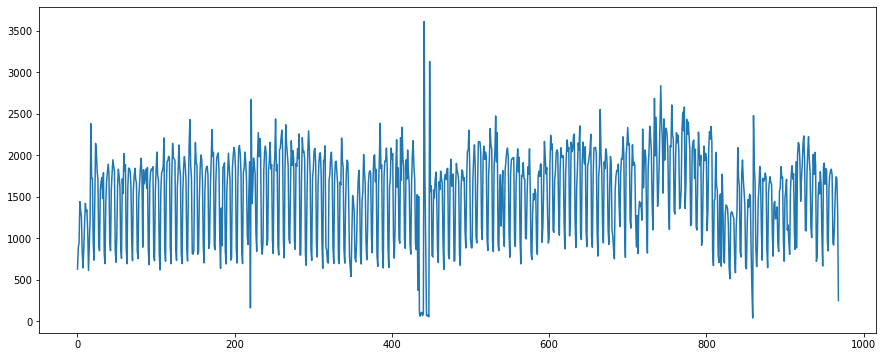

In [6]:
### Number of units coming in per day
### Typically ranges from 800-2000 daily, so definitely >5000 monthly
f1, ax1 = plt.subplots(1, figsize=[15, 6])
ax1.plot(range(units_per_day.shape[0]), units_per_day['n_units'], label='# units')

# Relevance scoring/binning

In [3]:
### Full dataset takes up too much memory, so dropping all but the most recent now
### This keeps 276122 of the original 1.5e6, or a little less than 1/5th of the total
df2 = df.loc[df['read_date'] >= '2019-03-01']
del df

In [59]:
new_units = df2['n_units'].sum()
downscale = new_units/units
print(new_units, downscale)

276122.0 0.18449151947830678


In [9]:
### Assign a made-up CPD relevance score

### Words associated with CPD
cop_words = [
    "cpd",
    "police",
    "officer",
    "cop",
    "officers",
    "pigs",
    "policeofficer",
  ]
### Count number of times relevant words appear in title or text
df2['cop_word_counts'] = 0
for w in cop_words:
    df2['cop_word_counts'] += df2['bodytext'].str.lower().str.count(w)
    df2['cop_word_counts'] += df2['title'].str.lower().str.count(w)

In [40]:
df2['cop_word_counts'].describe()

count    72783.000000
mean         1.801300
std          4.715337
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        240.000000
Name: cop_word_counts, dtype: float64

Text(0, 0.5, 'CPD_model')

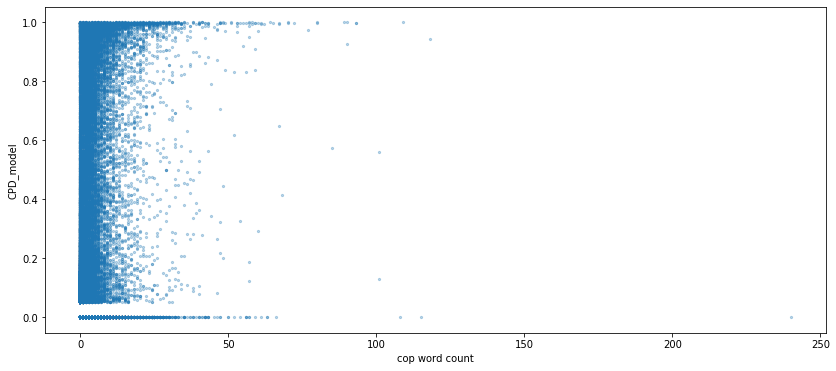

In [33]:
### Does the word count measure the same thing as the CPD_model column? 
### No, doesn't look very correlated actually...
f1, ax1 = plt.subplots(1, figsize=[14,6])
ax1.scatter(df2['cop_word_counts'], df2['CPD_model'], alpha=0.3, s=5)
ax1.set_xlabel('cop word count')
ax1.set_ylabel('CPD_model')

In [39]:
### See examples that use the relevant words but didn't score highly in CPD_model
### Some definitely look relevant (e.g. article 650870)
relevant_but_zero = df2.loc[(df2['CPD_model']==0) & ((df2['CPD']==0))].sort_values('cop_word_counts', ascending=False)
print(relevant_but_zero.loc[650870, 'title'])
print(relevant_but_zero.loc[650870, 'bodytext'])

Two Chicago police officers were accused of child abuse. A decade later, they were fired
Two Chicago police officers have been fired a decade after they were first
accused of hitting a child in their care and failing to seek medical attention
for the 8-year-old boy, who suffered fractures to the face and arm that the
child said was inflicted by one of the officers.

In voting 9-0 to dismiss Officers Yasmina Vaval and Teresa Foster, the Chicago
Police Board said it was “deeply troubled” that this case, and others, take so
long to resolve.

Advertisement

“The Board continues to be deeply troubled by cases such as this, in which the
charges were filed more than nine years after an incident occurs,” the board
wrote in a 28-page decision handed down last week. "In this case, the impact was
particularly serious on the victim, who was eight years old when abused and is
now an adult.”

The alleged abuse occurred in 2008 and 2009. The Illinois Department of Children
and Family Services removed

In [11]:
### Basic relevance score:
### - 50% human tagged "CPD"
### - 25% "CPD_model"
### - 25% usage of above words
df2['CPD_relevance'] = (  0.5*df2['CPD'] # upweight because it means more
                       + 0.25*df2['CPD_model']
                       + 0.25*(df2['cop_word_counts']/(2*len(cop_words))).clip(upper=1.)
                      )
### 55% have relevance = 0
### 
df['relevance_tier'] = 0
df.head()

In [13]:
### What number/fraction have score > 0?
print(df2.loc[df2['CPD_relevance']>0, 'n_units'].sum(), (df2['CPD_relevance']>0).mean())
### What number/fraction have score = 0?
print(df2.loc[df2['CPD_relevance']==0, 'n_units'].sum(), (df2['CPD_relevance']==0).mean())

137183.0 0.4499402332962368
138939.0 0.5500597667037632


(array([1.3792e+04, 3.8480e+03, 2.5010e+03, 2.5090e+03, 3.3170e+03,
        2.6980e+03, 1.5210e+03, 7.6300e+02, 5.6900e+02, 9.2700e+02,
        4.0000e+00, 4.0000e+00, 6.0000e+00, 2.2000e+01, 4.9000e+01,
        7.6000e+01, 4.4000e+01, 2.3000e+01, 2.5000e+01, 5.0000e+01]),
 array([0.0125025 , 0.06187737, 0.11125225, 0.16062712, 0.210002  ,
        0.25937687, 0.30875175, 0.35812662, 0.4075015 , 0.45687637,
        0.50625125, 0.55562612, 0.605001  , 0.65437587, 0.70375075,
        0.75312562, 0.8025005 , 0.85187537, 0.90125025, 0.95062512,
        1.        ]),
 <a list of 20 Patch objects>)

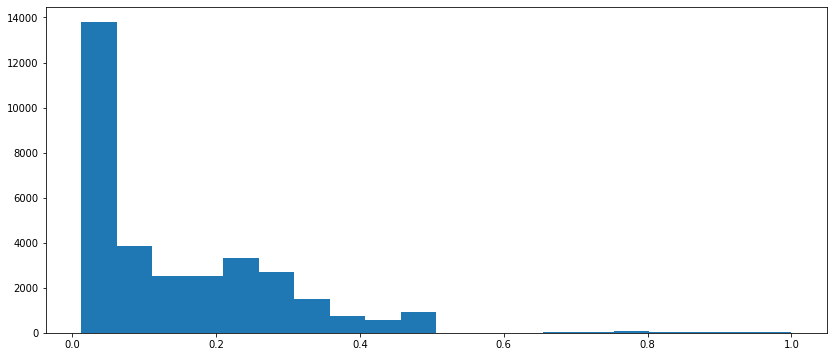

In [47]:
### About half of scores are 0
### What is the distribution of the nonzero ones?
nonzero_scores = df2.loc[df2['CPD_relevance']>0].sort_values('CPD_relevance', ascending=False)

f1, ax1 = plt.subplots(1, figsize=[14, 6])
ax1.hist(nonzero_scores['CPD_relevance'], bins=20)

In [60]:
5000*downscale

922.4575973915339

In [61]:
### Divide this sample into groups of 900 rows each, in order to get
### sizes needed for bins that would be ~5000 each.
### This ould actually be a bit too big, but you get the general idea
### Bins would have to get progressively smaller as we go down to stay equal in number
nonzero_scores['CPD_relevance'].iloc[[i*900 for i in range(1, int(np.ceil(nonzero_scores.shape[0]/900)))]]

article_id
615662    0.485132
652807    0.407189
630258    0.353261
624546    0.320860
608502    0.299458
646388    0.281343
642065    0.266771
595837    0.252939
651855    0.247067
639736    0.231753
649482    0.214238
649597    0.196261
654330    0.178571
598984    0.160714
597207    0.142857
648693    0.125000
617132    0.107143
592013    0.095360
619221    0.086230
648261    0.071429
618711    0.062814
637667    0.053571
589184    0.049998
635322    0.037251
649248    0.035714
643199    0.035714
611136    0.032706
583819    0.025020
603843    0.018614
601597    0.017857
649000    0.017857
582941    0.017857
635029    0.017857
607456    0.017857
616191    0.017857
610175    0.013737
Name: CPD_relevance, dtype: float64